<a href="https://colab.research.google.com/github/fghory/agent-world/blob/main/Agentia_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture --no-stderr
%pip install --quiet -U  langgraph langchain_community langchain_openai langchain_google_genai langchain_core langgraph-checkpoint-postgres psycopg psycopg2 psycopg-pool trustcall

In [ ]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["GEMINI_API_KEY"] = userdata.get('GEMINI_API_KEY')
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [ ]:
AGENTIA_DB_URI = userdata.get('AGENTIA_DB_URI')
AGENTIA_LT_MEM_URI = userdata.get('AGENTIA_LT_MEM_URI')

In [ ]:
from typing import Literal
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.base import BaseStore
from trustcall import create_extractor


#members = ["greetings", "user_info"]
members = ["greetings", "user"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

llm_openai = ChatOpenAI(model="gpt-4o")

# Schema for long-term memory
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

# Create the extractor
trustcall_extractor = create_extractor(
    llm_openai,
    tools=[UserProfile],
    tool_choice="UserProfile", # Enforces use of the UserProfile tool
)


class Router(BaseModel):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal["greetings", "user", "FINISH"]

# When no further routing is required, respond with FINISH.
system_message = """
You are a supervisor tasked with managing a conversation between the following workers: {members}.
You are also a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses. Here is the memory (it may be empty): {memory}.

Analyze the user's request and determine the appropriate next worker based on these rules:
  1. If the user first message:
    a) include only greeting or greeting with other content : route to the 'greetings' agent. Ensure that you route to greeting node only once!
    b) does not include greeting: always route to the 'user' agent.
  2. After the 'greetings' agent responds, transition to the 'user' node to continue the conversation.
  3. Carefully understand the user request and go back to the 'user' node with your appropriate response.
  4. Always route to the 'user' node after fulfilling the user's request to engage in further dialogue.
  5. If the user's request can be fulfilled without involving other agents, respond directly and then transition to the 'user' node.
  6. If the user indicates the end of the conversation or no further action is required:
    a) Respond to user with something like 'Thank you for reaching out! Have a great day!' or 'It was a pleasure assisting you. Take care!'
    b) and afterwards transition to the '__end__' node.

  NOTE:
  DO NOT ROUTE TO GREETING NODE WITH EMPTY MESSAGE
  IF USER INTENT IS TO END CONSERVATON ALWAYS RESPOND TO USER WITH SOME NICE WORDS AND THEN GO TO '__end__' NODE
"""

def supervisor_node(state: MessagesState,  config: RunnableConfig, store: BaseStore) -> Command[Literal["greetings", "user", "__end__"]]:

    """Load memory from the store and use it to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    system_prompt = system_message.format(memory=formatted_memory, members=members)

    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm_openai.with_structured_output(Router).invoke(messages)
    goto = response.next
    if goto == "FINISH":
        goto = END

    # Determine the last active node from the latest AIMessage
    last_message = state["messages"][-1] if state["messages"] else None
    last_active_node = last_message.name if last_message else None

    # If the last active node was the greetings agent, transition to the user node
    if last_active_node == "greetings":
        return Command(goto="user", update={"messages": state["messages"]})

    # To ensure that only llm generated response is sent to user if last node is not greetings
    if goto == "user" and last_active_node != "greetings":
        # Generate a direct response
        supervisor_response = llm_openai.invoke(messages)
        # Validate the response content before adding it to the state
        if not supervisor_response.content:
            raise ValueError("Empty response generated by the supervisor node.")

        new_message = AIMessage(content=supervisor_response.content, name="supervisor")
        updated_messages = state["messages"] + [new_message]
        return Command(goto=goto, update={"messages": updated_messages})
    update = {"messages": state["messages"]}
    return Command(goto=goto, update=update)

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

llm_gemni = ChatGoogleGenerativeAI(model="gemini-1.5-flash",  api_key = GEMINI_API_KEY)

def greetings_node(state: MessagesState) -> Command[Literal["supervisor"]]:

    system_prompt = ("""You are a greetings agent. Your task is to reply the user in reponse to the greetings message.
    You should reply in the same language in which the user has said his/her greeting.
    Add a polite sentence like How can I help you ? or something similar in your response
     """)

    # Debug print to check the state messages
    print("State messages:", state["messages"])

    # Ensure that state["messages"] is not empty
    if not state["messages"]:
        raise ValueError("No messages found in the state.")

    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]

    # Debug print to check the final messages being passed to the model
    print("Final messages to llm_gemni:", messages)

    result = llm_gemni.invoke(messages)
    return Command(
        update={
            "messages": [
                AIMessage(content=result.content, name="greetings")
            ],
        },
        goto="supervisor",
    )


    # messages = [
    #     {"role": "system", "content": system_prompt},
    # ] + state["messages"]
    # result = llm_gemni.invoke(messages)
    # return Command(
    #     update={
    #         "messages": [
    #             AIMessage(content=result.content, name="greetings")
    #         ],
    #     },
    #     goto="supervisor",
    # )




In [ ]:
from langgraph.types import interrupt

def user_node(state: MessagesState) -> Command[Literal["supervisor", "write_memory"]]:
  value = interrupt("user response: ")

  return Command(
        update={
            "messages": [
                HumanMessage(content=value, name="user")
            ],
        },
        goto=["supervisor","write_memory"]
    )

In [ ]:
# Extraction instruction
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None

    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state["messages"], "existing": existing_profile})

    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)



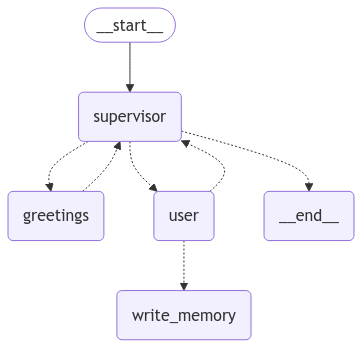

In [ ]:
from IPython.display import Image, display
from psycopg_pool import ConnectionPool
from langgraph.checkpoint.postgres import PostgresSaver
from langgraph.store.memory import InMemoryStore
from langgraph.store.postgres import PostgresStore
from langgraph.checkpoint.memory import MemorySaver

# Connection pool for efficient database access
connection_kwargs = {"autocommit": True, "prepare_threshold": 0}

# Create a persistent connection pool
pool = ConnectionPool(conninfo=AGENTIA_DB_URI, max_size=20, kwargs=connection_kwargs)

# Initialize PostgresSaver checkpointer
checkpointer = PostgresSaver(pool)
checkpointer.setup()  # Ensure database tables are set up

# checkpointer = MemorySaver()

# Store for long-term (across-thread) memory

pool1 = ConnectionPool(conninfo=AGENTIA_LT_MEM_URI, max_size=20, kwargs=connection_kwargs)
store = PostgresStore(pool1)
store.setup()
#across_thread_memory = InMemoryStore()


builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("greetings", greetings_node)
builder.add_node("user", user_node)
builder.add_node("write_memory", write_memory)


graph = builder.compile(checkpointer=checkpointer, store=store)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Specify a thread
config = {"configurable": {"thread_id": "107", "user_id": "106"}}

# Specify an input
messages = [HumanMessage(content="who is Ameen?")]

# Start conversation
for chunk in graph.stream({"messages": messages}, config, stream_mode="updates"):
  # print(chunk)
  if 'supervisor' in chunk:
    ai_messages = [msg for msg in chunk['supervisor']['messages'] if isinstance(msg, AIMessage)]
    # Print the content of each AIMessage
    if ai_messages:
            # Access the last AIMessage using negative indexing
            latest_ai_message = ai_messages[-1]
            # Print the content of the latest AIMessage
            print(latest_ai_message.content)

Ameen is a user interested in bakeries in Karachi, particularly those with dine-in facilities. Ameen is located in Islamabad. How can I assist you further?


In [ ]:
# Specify a thread
config = {"configurable": {"thread_id": "131", "user_id": "131"}}

# Specify an input
messages = [HumanMessage(content="Ni Hao!, How are you doing?")]

# Start conversation
for chunk in graph.stream({"messages": messages}, config, stream_mode="updates"):
  # print(chunk)
  if 'supervisor' in chunk:
    ai_messages = [msg for msg in chunk['supervisor']['messages'] if isinstance(msg, AIMessage)]
    # Print the content of each AIMessage
    if ai_messages:
            # Access the last AIMessage using negative indexing
            latest_ai_message = ai_messages[-1]
            # Print the content of the latest AIMessage
            print(latest_ai_message.content)

State messages: [HumanMessage(content='Ni Hao!, How are you doing?', additional_kwargs={}, response_metadata={}, id='3ebc500e-5387-478c-9015-4854dfb91541')]
Final messages to llm_gemni: [{'role': 'system', 'content': 'You are a greetings agent. Your task is to reply the user in reponse to the greetings message.\n    You should reply in the same language in which the user has said his/her greeting.\n    Add a polite sentence like How can I help you ? or something similar in your response\n     '}, HumanMessage(content='Ni Hao!, How are you doing?', additional_kwargs={}, response_metadata={}, id='3ebc500e-5387-478c-9015-4854dfb91541')]
你好！(Nǐ hǎo!) I'm doing well, thank you. How may I assist you today?


In [ ]:
state = graph.get_state(config)
state

StateSnapshot(values={'messages': [HumanMessage(content='Hi, My name is Jameel and I am an Telecommunication Engineer. How are you doing?', additional_kwargs={}, response_metadata={}, id='698cc4a9-4dea-4b3b-a174-df799829c488'), AIMessage(content="Hi Jameel, It's nice to meet you. I am doing well, thank you for asking. How can I help you?", additional_kwargs={}, response_metadata={}, name='greetings', id='8f580a6d-f2e5-4ef8-afe5-7d6fac0b9cd1')]}, next=('user',), config={'configurable': {'thread_id': '110', 'checkpoint_ns': '', 'checkpoint_id': '1efd248a-3bc1-62bb-8003-af782cfa7491'}}, metadata={'step': 3, 'source': 'loop', 'writes': {'supervisor': {'messages': [HumanMessage(content='Hi, My name is Jameel and I am an Telecommunication Engineer. How are you doing?', additional_kwargs={}, response_metadata={}, id='698cc4a9-4dea-4b3b-a174-df799829c488'), AIMessage(content="Hi Jameel, It's nice to meet you. I am doing well, thank you for asking. How can I help you?", additional_kwargs={}, re

In [ ]:
for chunk in graph.stream(Command(resume="I want to know about bakeries in Karachi"), config, stream_mode="updates"):
  # print(chunk)
  if 'supervisor' in chunk:
    ai_messages = [msg for msg in chunk['supervisor']['messages'] if isinstance(msg, AIMessage)]
    # Print the content of each AIMessage
    if ai_messages:
            # Access the last AIMessage using negative indexing
            latest_ai_message = ai_messages[-1]
            # Print the content of the latest AIMessage
            print(latest_ai_message.content)

Karachi has a rich variety of bakeries offering delicious treats. Some famous ones include:

1. Pie in the Sky - Known for its cakes and desserts.
2. United King - Offers a range of sweets and baked goods.
3. Delizia - Popular for its cakes and pastries.
4. Hobnob Bakery - Offers a wide variety of baked items.
5. Sacha’s - Known for its delectable cakes and snacks.

Do you need any specific recommendations or are you looking for something particular?


In [ ]:
# Namespace for the memory to save
user_id = "108"
namespace = ("memory", user_id)
existing_memory = store.get(namespace, "user_memory")
existing_memory.value

{'interests': [], 'user_name': 'Ameen', 'user_location': 'Isb'}

In [ ]:
state = graph.get_state(config)
state.next

('user',)

In [ ]:
for chunk in graph.stream(Command(resume="Do these bakeries have dine in facility?"), config, stream_mode="updates"):
  # print(chunk)
  if 'supervisor' in chunk:
    ai_messages = [msg for msg in chunk['supervisor']['messages'] if isinstance(msg, AIMessage)]
    # Print the content of each AIMessage
    if ai_messages:
            # Access the last AIMessage using negative indexing
            latest_ai_message = ai_messages[-1]
            # Print the content of the latest AIMessage
            print(latest_ai_message.content)

Most of these bakeries primarily focus on takeaway services, but a few may offer limited dine-in facilities. It's best to check with individual bakeries for their dining options, as this can vary. Pie in the Sky and Hobnob Bakery sometimes have seating areas where you can enjoy your treats. Let me know if you need more specific information or assistance!


In [ ]:
# Namespace for the memory to save
user_id = "108"
namespace = ("memory", user_id)
existing_memory = store.get(namespace, "user_memory")
existing_memory.value

{'interests': [], 'user_name': 'Ameen', 'user_location': 'Isb'}

In [ ]:
for chunk in graph.stream(Command(resume="Thank You for now!"), config, stream_mode="updates"):
  print(chunk)
  # if 'supervisor' in chunk:
  #   ai_messages = [msg for msg in chunk['supervisor']['messages'] if isinstance(msg, AIMessage)]
  #   # Print the content of each AIMessage
  #   if ai_messages:
  #           # Access the last AIMessage using negative indexing
  #           latest_ai_message = ai_messages[-1]
  #           # Print the content of the latest AIMessage
  #           print(latest_ai_message.content)

Most of these bakeries primarily focus on takeaway services, but a few may offer limited dine-in facilities. It's best to check with individual bakeries for their dining options, as this can vary. Pie in the Sky and Hobnob Bakery sometimes have seating areas where you can enjoy your treats. Let me know if you need more specific information or assistance!


In [ ]:
state = graph.get_state(config)
state.next

()

In [ ]:
pool.close()

In [ ]:
pool1.close()